<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Image_to_Image_Translation_with_Conditional_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image-to-Image Translation with Conditional Adversarial Networks**

링크: https://arxiv.org/abs/1611.07004

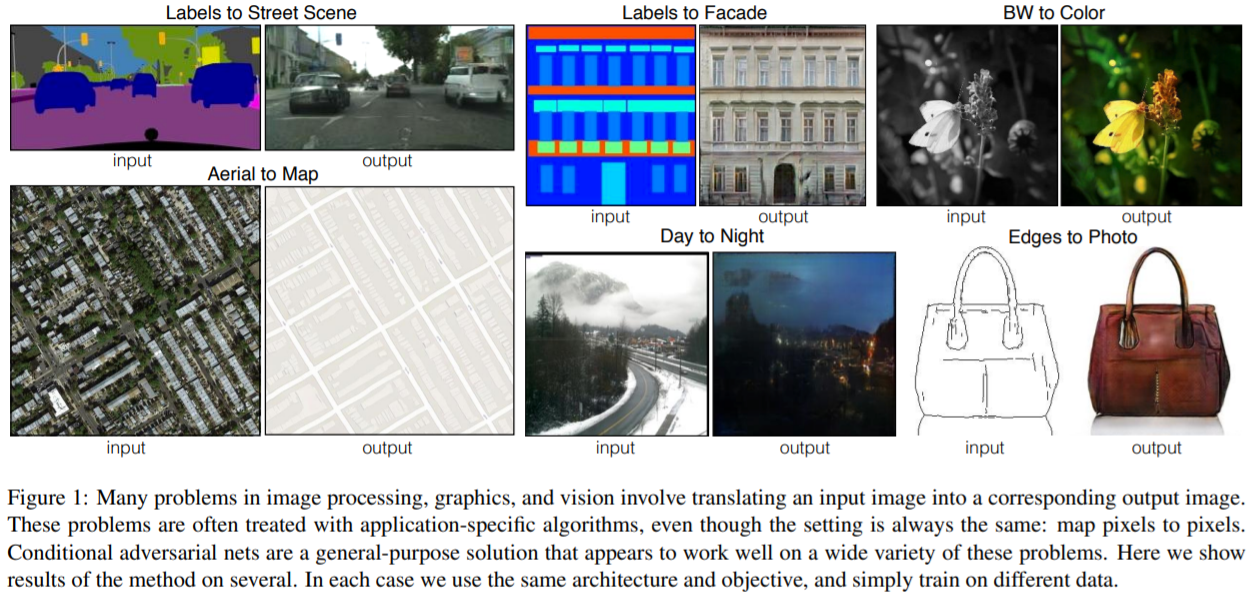

predict image와 ground truth이미지의 Euclidean distance를 minimize하므로서 Image-to-Image Translation을 하지만 이것은 blurry한 결과를 가져온다. 왜냐하면 output들의 average한 결과를 토대로 Euclidean distance를 감소시키기 때문이다. 따라서 해당 논문인 Pix2Pix는 Euclidean distance를 minimize하는 것은 low frequency한 부분에서 효과적이지만 high frequency를 살리지 못하기 때문에 논문에서는 **L1 loss와 gan loss를 동시에 사용**한다. 

## **Pix2Pix**

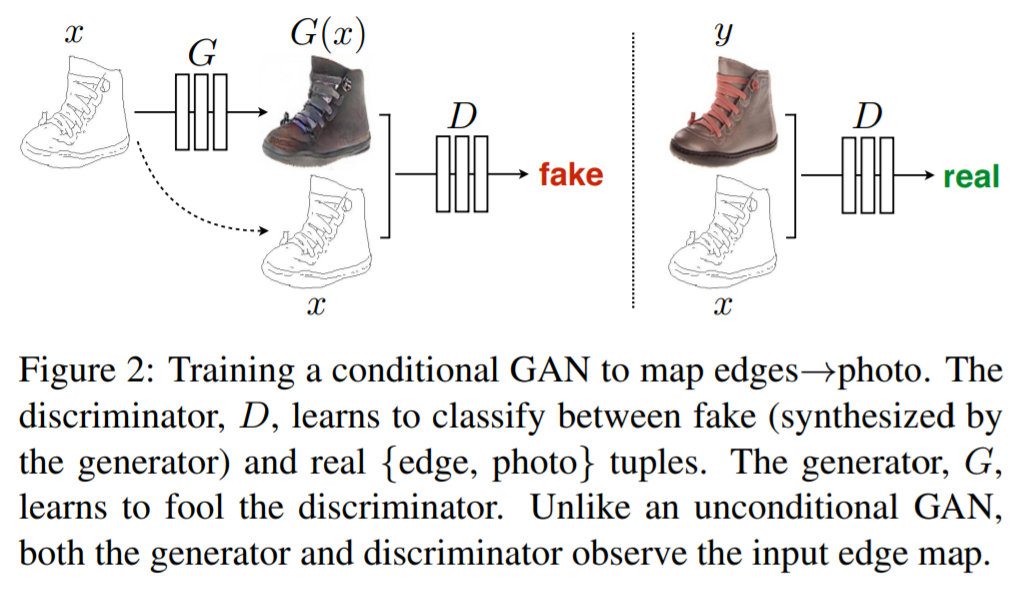

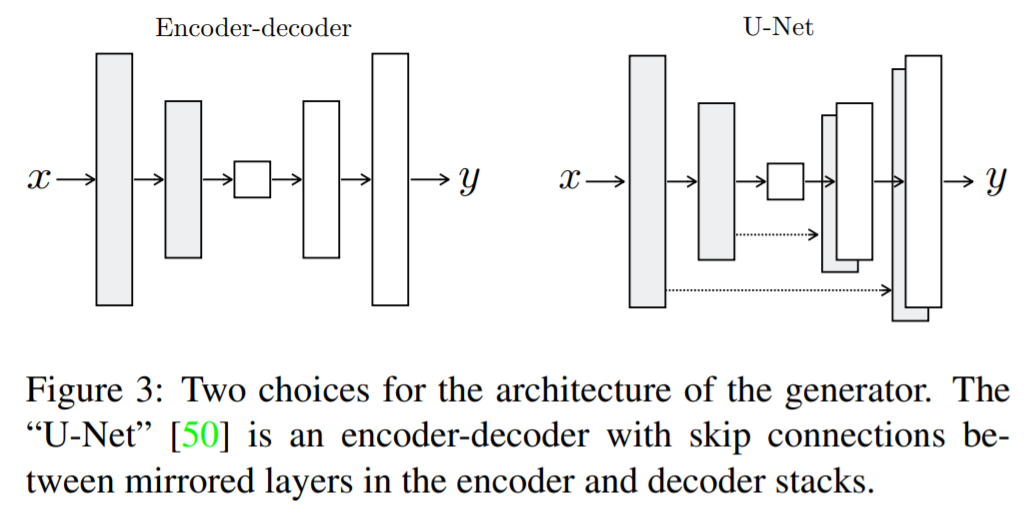

위 그림 Figure 2는 모델의 전반적인 구조에 대해 나와있다. 당연히 image에서 image로 mapping하기 때문에 Conditional GAN이 사용된다. generator와 discriminator둘 다 input 이미지가 들어간다. 논문의 generator의 구조는 위의 그림 Figure 3과 같이 encoder과 (decoder or U-Net decoder)가 사용되었다. 그리고 discriminator의 구조에는 PatchGAN이 사용되었다. 

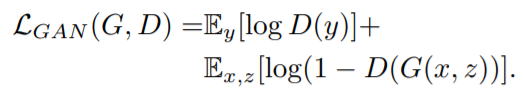

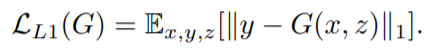

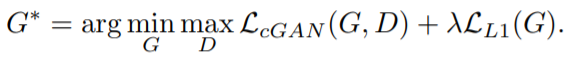

loss function의 경우는 기존 CGAN의 loss function(다른점은 pix2pix에서 noise vector z가 사용되지 않고 x라는 input 이미지가 generator에 입력으로서 사용된다.)에 추가적으로 low frequency한 부분을 살리기위해서 L1 loss를 hyper-parameter인 λ에 곱해서 더해준다.

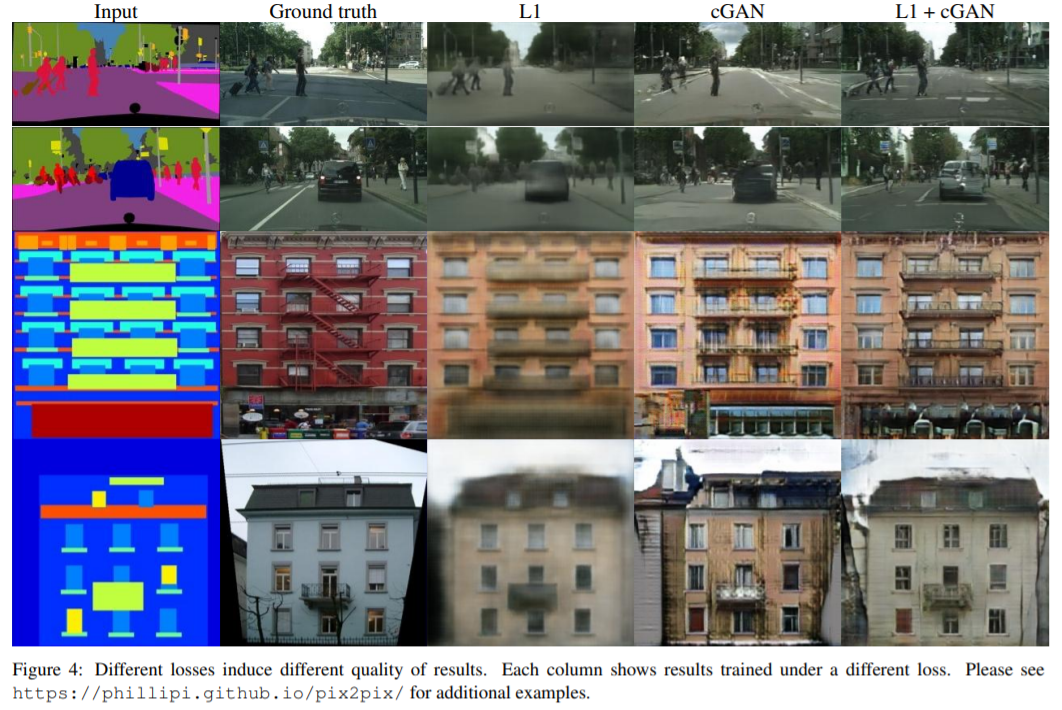

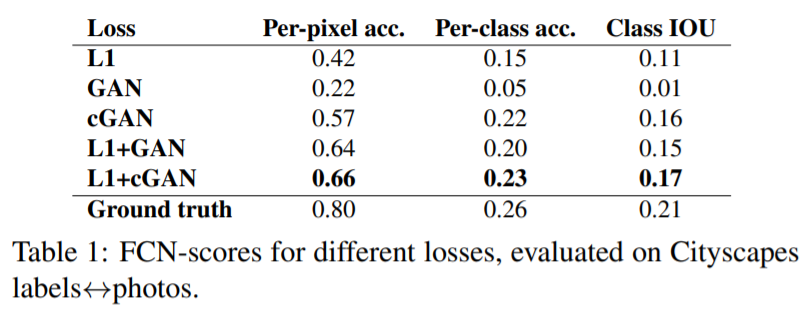

위의 그림 Figure 4과 표 Table 1은 loss function에 대해 각각의 결과뮬을 보여준 것이다. 결과적으로 L1 + cGAN이 가장 좋은 결과를 도출해낸 것을 확인할 수 있다.

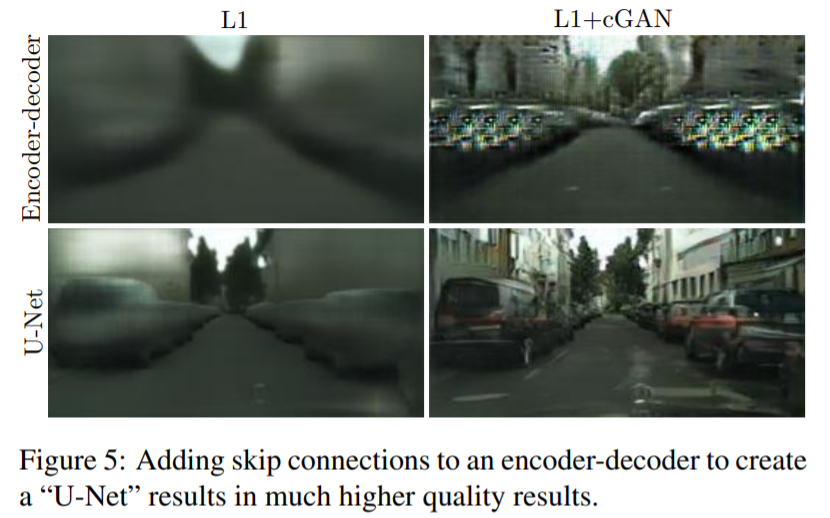

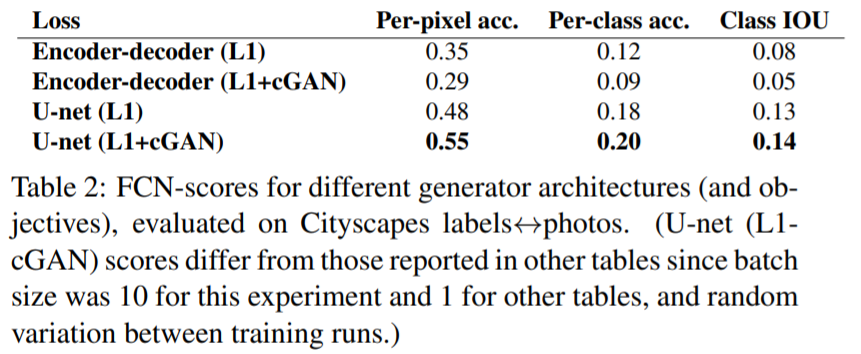

위의 그림 Figure 5와 표 Table 2는 위에서 말했던 generator에서 encoder-decoder 형태와 U-Net 형태의 결과물을 보여준다. 확실히 skip-connection을 사용한 U-Net이 더 좋은 결과물을 만들어 내는 것을 확인힐 수 있다.

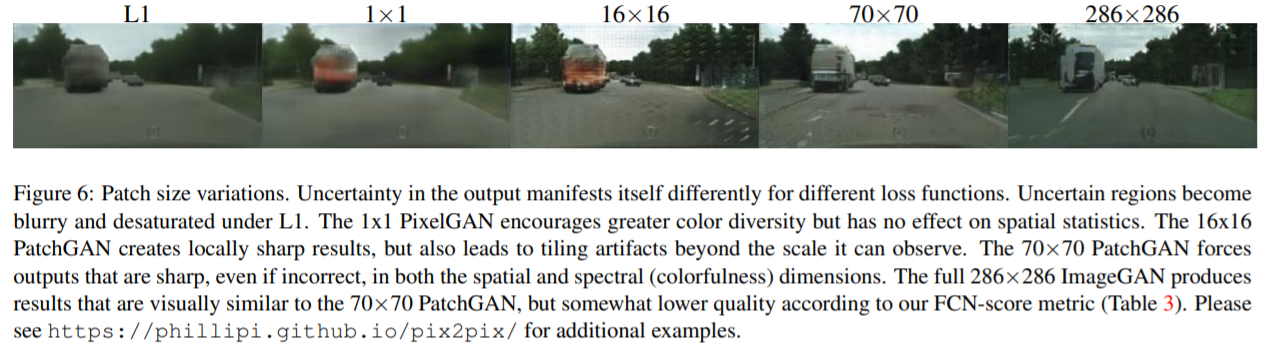

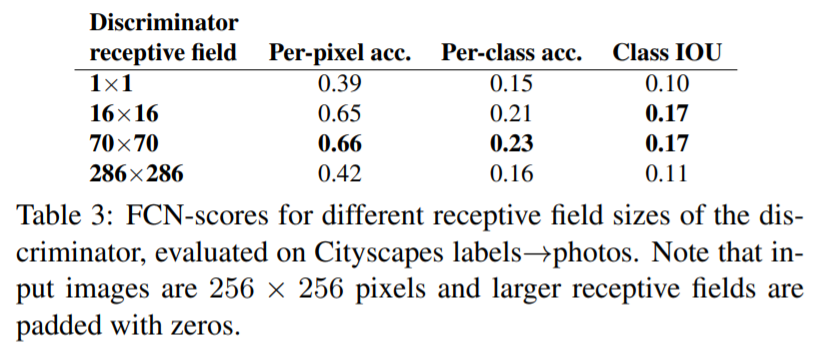

위의 그림 Figure 6과 표 Table 3은 Patch size를 조정해 receptive field에 따른 결과를 보여준다. 무조건 크거나 작다고 좋은 결과를 가져오는건아니고 위의 이미지에서는 70x70이 가장 좋은 결과를 가져왔다.

### **Pytorch**

논문의 최하단에 위치해 있는 Network architectures와 Training details를 참고해 pytorch로 구현을 해보았다.

1. input image에 **random jitter**를 적용했다. 256 x 256이미지를 286 x 286으로 resize한 뒤 random crop하여 256 x 256으로 조절했다.
2. 가중치 초기화를 진행했다. 가우시안 분포 mean 0 , standard deviation 0.02
3. 이미지 데이터 셋마다 적용한 batch size가 다르다

(네트워크 구조는 아래 코드를 보면 알 수 있다.)

In [1]:
import torch
import torch.nn as nn

# Pix2Pix Generator
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, nker=64, norm='bnorm'):
        super(Generator, self).__init__()

        # encoder
        self.enc1 = CBR2d(in_channels, 1 * nker, kernel_size=4, stride=2, padding=1, norm=None, relu=0.2)
        self.enc2 = CBR2d(1 * nker, 2 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.2)
        self.enc3 = CBR2d(2 * nker, 4 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.2)
        self.enc4 = CBR2d(4 * nker, 8 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.2)
        self.enc5 = CBR2d(8 * nker, 8 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.2)
        self.enc6 = CBR2d(8 * nker, 8 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.2)
        self.enc7 = CBR2d(8 * nker, 8 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.2)
        self.enc8 = CBR2d(8 * nker, 8 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.2)
        
        # U-Net decoder
        self.dec1 = DECBRD2d(8 * nker, 8 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.0, drop=0.5)
        # skip connection
        self.dec2 = DECBRD2d(2 * 8 * nker, 8 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.0, drop=0.5)
        self.dec3 = DECBRD2d(2 * 8 * nker, 8 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.0, drop=0.5)
        self.dec4 = DECBRD2d(2 * 8 * nker, 8 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.0, drop=None)
        self.dec5 = DECBRD2d(2 * 8 * nker, 4 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.0, drop=None)
        self.dec6 = DECBRD2d(2 * 4 * nker, 2 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.0, drop=None)
        self.dec7 = DECBRD2d(2 * 2 * nker, 1 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.0, drop=None)
        self.dec8 = DECBRD2d(2 * 1 * nker, out_channels, kernel_size=4, stride=2, padding=1, norm=None, relu=None, drop=None)

        self.tanh = nn.Tanh()

    def forward(self, x):
        # encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        enc6 = self.enc6(enc5)
        enc7 = self.enc7(enc6)
        enc8 = self.enc8(enc7)
        
        # decoder
        dec1 = self.dec1(enc8)
        
        cat2 = torch.cat((dec1, enc7), dim=1)
        dec2 = self.dec2(cat2)

        cat3 = torch.cat((dec2, enc6), dim=1)
        dec3 = self.dec3(cat3)

        cat4 = torch.cat((dec3, enc5), dim=1)
        dec4 = self.dec4(cat4)

        cat5 = torch.cat((dec4, enc4), dim=1)
        dec5 = self.dec5(cat5)

        cat6 = torch.cat((dec5, enc3), dim=1)
        dec6 = self.dec6(cat6)

        cat7 = torch.cat((dec6, enc2), dim=1)
        dec7 = self.dec7(cat7)

        cat8 = torch.cat((dec7, enc1), dim=1)
        dec8 = self.dec8(cat8)

        x = self.tanh(dec8)

        return x

# Pix2Pix Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels, out_channels, nker=64, norm='bnorm'):
        super(Discriminator, self).__init__()

        self.enc1 = CBR2d(1 * in_channels, 1 * nker, kernel_size=4, stride=2, padding=1, norm=None, relu=0.2, bias=False)
        self.enc2 = CBR2d(1 * nker, 2 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.2, bias=False)
        self.enc3 = CBR2d(2 * nker, 4 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.2, bias=False)
        self.enc4 = CBR2d(4 * nker, 8 * nker, kernel_size=4, stride=2, padding=1, norm=norm, relu=0.2, bias=False)
        self.enc5 = CBR2d(8 * nker, out_channels, kernel_size=4, stride=2, padding=1, norm=None, relu=None, bias=False)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        x = self.enc5(x)
        
        x = self.sig(x)

        return x

class DECBRD2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, norm='bnorm', relu=0.0, drop=0.5):
        super().__init__()

        layers = []
        layers += [nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                    kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]

        if not norm is None:
            if norm == 'bnorm':
                layers += [nn.BatchNorm2d(num_features=out_channels)]
            elif norm == 'inorm':
                layers += [nn.InstanceNorm2d(num_features=out_channels)]

        if not relu is None and relu >= 0.0:
            layers += [nn.ReLU() if relu == 0 else nn.LeakyReLU(relu)]

        if not drop is None:
            layers += [nn.Dropout2d(drop)]

        self.cbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.cbr(x)


class CBR2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, norm='bnorm', relu=0.0):
        super().__init__()

        layers = []
        layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                    kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]

        if not norm is None:
            if norm == 'bnorm':
                layers += [nn.BatchNorm2d(num_features=out_channels)]
            elif norm == 'inorm':
                layers += [nn.InstanceNorm2d(num_features=out_channels)]

        if not relu is None and relu >= 0.0:
            layers += [nn.ReLU() if relu == 0 else nn.LeakyReLU(relu)]

        self.cbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.cbr(x)